In [1]:
library(cowplot)
library(tidyverse)
library(reticulate)

np <- import("numpy")

i <- np$load("../results/real_world/Xy.npz", allow_pickle=TRUE)
X <- i$f[['X']]
y <- i$f[['Y']]
genes <- i$f[['genes']]

theme_transparent <- theme(panel.background = element_rect(fill = "transparent"), # bg of the panel
                           plot.background = element_rect(fill = "transparent", color = NA), # bg of the plot
                           panel.grid.major = element_blank(), # get rid of major grid
                           panel.grid.minor = element_blank(), # get rid of minor grid
                           legend.background = element_rect(fill = "transparent", color = NA), # get rid of legend bg
                           legend.box.background = element_rect(fill = "transparent", color = NA) # get rid of legend panel bg
                          )

color_palette <- c(
#              "MMD\n(linear)" = rgb(165/255,15/255,21/255),
#              "MMD\n(distance)" = rgb(252/255,187/255,161/255),
#              "MMD\n(gaussian)" = rgb(239/255,59/255,44/255),
#              "cMMD\n(linear)" = rgb(165/255,15/255,21/255),
#              "cMMD\n(distance)" = rgb(252/255,187/255,161/255),
             "cMMD\n(gaussian)" = rgb(239/255,59/255,44/255),
#              "HSIC\n(distance)" = rgb(198/255,219/255,239/255),
#              "HSIC\n(linear)" = rgb(8/255,81/255,156/255),
             "HSIC\n(gaussian)" = rgb(107/255,174/255,214/255),
             "TR" = rgb(253/255,191/255,111/255),
             "Pearson" = rgb(106/255,61/255,154/255),
             "PC" = rgb(116/255,196/255,118/255),
             "DC" = rgb(177/255,89/255,40/255)
        )

── Attaching packages ───────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
brca <- read_csv('../results/real_world/brca_scores.csv', col_types = 'cicdcddd') %>%
    mutate(features = strsplit(features, ',')) %>%
    mutate(AM = ifelse(AM == 'pearson_correlation', 'Pearson', AM),
           AM = ifelse(AM == 'HSIC', 'HSIC\n(gaussian)', AM),
           AM = ifelse(AM == 'MMD', 'cMMD\n(gaussian)', AM)) %>%
    unnest(features) %>%
    mutate(features = genes[as.numeric(features) + 1])

In [3]:
options(repr.plot.width=15, repr.plot.height=7)
acc_plt <- brca %>%
    select(fold, AM, alpha, accuracy, sensitivity, specificity) %>%
    unique %>%
    ggplot(aes(x = AM, y = accuracy, alpha = as.character(alpha))) +
        geom_boxplot(fill = 'red', outlier.alpha = 1) +
        labs(x = 'Association measure', y = 'Test accuracy', alpha = expression(alpha)) +
#         scale_y_continuous(limits = c(0, 1)) +
        theme_minimal() +
        guides(alpha = guide_legend(nrow = 2))+ 
        theme(text = element_text(size = 25),
              legend.position = 'bottom') +
        theme_transparent

In [4]:
num_features_plt <- brca %>%
    group_by(alpha, AM, fold) %>%
    summarize(n_features = n()) %>%
    group_by(alpha, AM) %>%
    summarize(sd = 1.96 * sd(n_features) / sqrt(n()), # fix
              n_features = mean(n_features)) %>%
    mutate(n_features = ifelse(AM == 'PC', n_features + .6, n_features),
           n_features = ifelse(AM == 'TR', n_features - .6, n_features),
           n_features = ifelse(AM == 'cMMD\n(gaussian)', n_features + .5, n_features),
           n_features = ifelse(AM == 'HSIC\n(gaussian)', n_features - .5, n_features)) %>%
    ggplot(aes(x = alpha, y = n_features, color = AM)) +
        geom_point(size = 4) +
        geom_errorbar(aes(ymin = n_features - sd, ymax = n_features + sd), 
                      width = 0.02, size = 1) +
        geom_line(size = 1.5) +
        guides(color = guide_legend(nrow = 1))+ 
        labs(y = '# features', color = 'Association measure', x = expression(alpha)) +
        theme_minimal() +
        theme(text = element_text(size = 25),
              legend.position = 'bottom') +
        theme_transparent +
        scale_color_manual(values = color_palette)

`summarise()` has grouped output by 'alpha', 'AM'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'alpha'. You can override using the `.groups` argument.



In [5]:
compute_pearson <- function(selection_vectors) {
    
    pearsons <- lapply(selection_vectors, function(x) {
        suppressWarnings(
            lapply(selection_vectors, cor, x)
        )
    }) %>% 
        unlist %>%
        matrix(nrow = length(selection_vectors))
    
    diag(pearsons) <- NA
    
    mean(pearsons, na.rm = TRUE)    
    
}

feature_vectors <- brca %>%
    group_by(alpha, AM, fold) %>%
    summarise(features = list(genes %in% features))

pearsons <- lapply(unique(brca$AM), function(am) {
        lapply(unique(brca$alpha), function(a) {
            
            selection_vectors <- filter(feature_vectors, AM == am, alpha == a)$features
            
            tibble(AM = am,
                   alpha = a,
                   pearson = compute_pearson(selection_vectors))

        })
}) %>% bind_rows

`summarise()` has grouped output by 'alpha', 'AM'. You can override using the `.groups` argument.



In [6]:
missing_plt <- read_csv('../results/real_world/brca_scores.csv', col_types = 'cicdcddd') %>%
    mutate(AM = ifelse(AM == 'pearson_correlation', 'Pearson', AM),
           AM = ifelse(AM == 'HSIC', 'HSIC\n(gaussian)', AM),
           AM = ifelse(AM == 'MMD', 'cMMD\n(gaussian)', AM)) %>%
    group_by(AM, alpha) %>%
    summarize(missing = sum(is.na(features))) %>%
    mutate(missing = ifelse(AM == 'PC', missing + .1, missing),
           missing = ifelse(AM == 'TR', missing - .1, missing),
           missing = ifelse(AM == 'cMMD\n(gaussian)', missing + .04, missing),
           missing = ifelse(AM == 'HSIC\n(gaussian)', missing - .04, missing)) %>%
    ggplot(aes(x = alpha, y = missing, color = AM)) +
        geom_point(size = 4) +
        geom_line(size = 1.5) +
        labs(y = '# folds no selection', color = 'Association measure', x = expression(alpha)) +
        scale_y_continuous(limits = c(0, 8)) +
        theme_minimal() +
        theme(text = element_text(size = 25),
              legend.position = 'none') +
        theme_transparent +
        scale_color_manual(values = color_palette)

`summarise()` has grouped output by 'AM'. You can override using the `.groups` argument.



In [7]:
pearson_plt <- pearsons %>%
    mutate(pearson = ifelse(AM == 'cMMD\n(gaussian)', pearson + .003, pearson),
           pearson = ifelse(AM == 'HSIC\n(gaussian)', pearson - .003, pearson)) %>%
    ggplot(aes(alpha, pearson, color = AM)) +
        geom_point(size = 4) +
        geom_line(size = 1.5) +
        labs(y = 'Cross-fold correlation', color = 'Association measure', 
             x = expression(alpha)) +
        theme_minimal() +
        theme(text = element_text(size = 25),
              legend.position = 'none') +
        theme_transparent +
        scale_color_manual(values = color_palette)

Warning message:
“Removed 20 rows containing missing values (geom_point).”
Warning message:
“Removed 20 row(s) containing missing values (geom_path).”
Warning message:
“Removed 25 rows containing missing values (geom_point).”
Warning message:
“Removed 25 row(s) containing missing values (geom_path).”


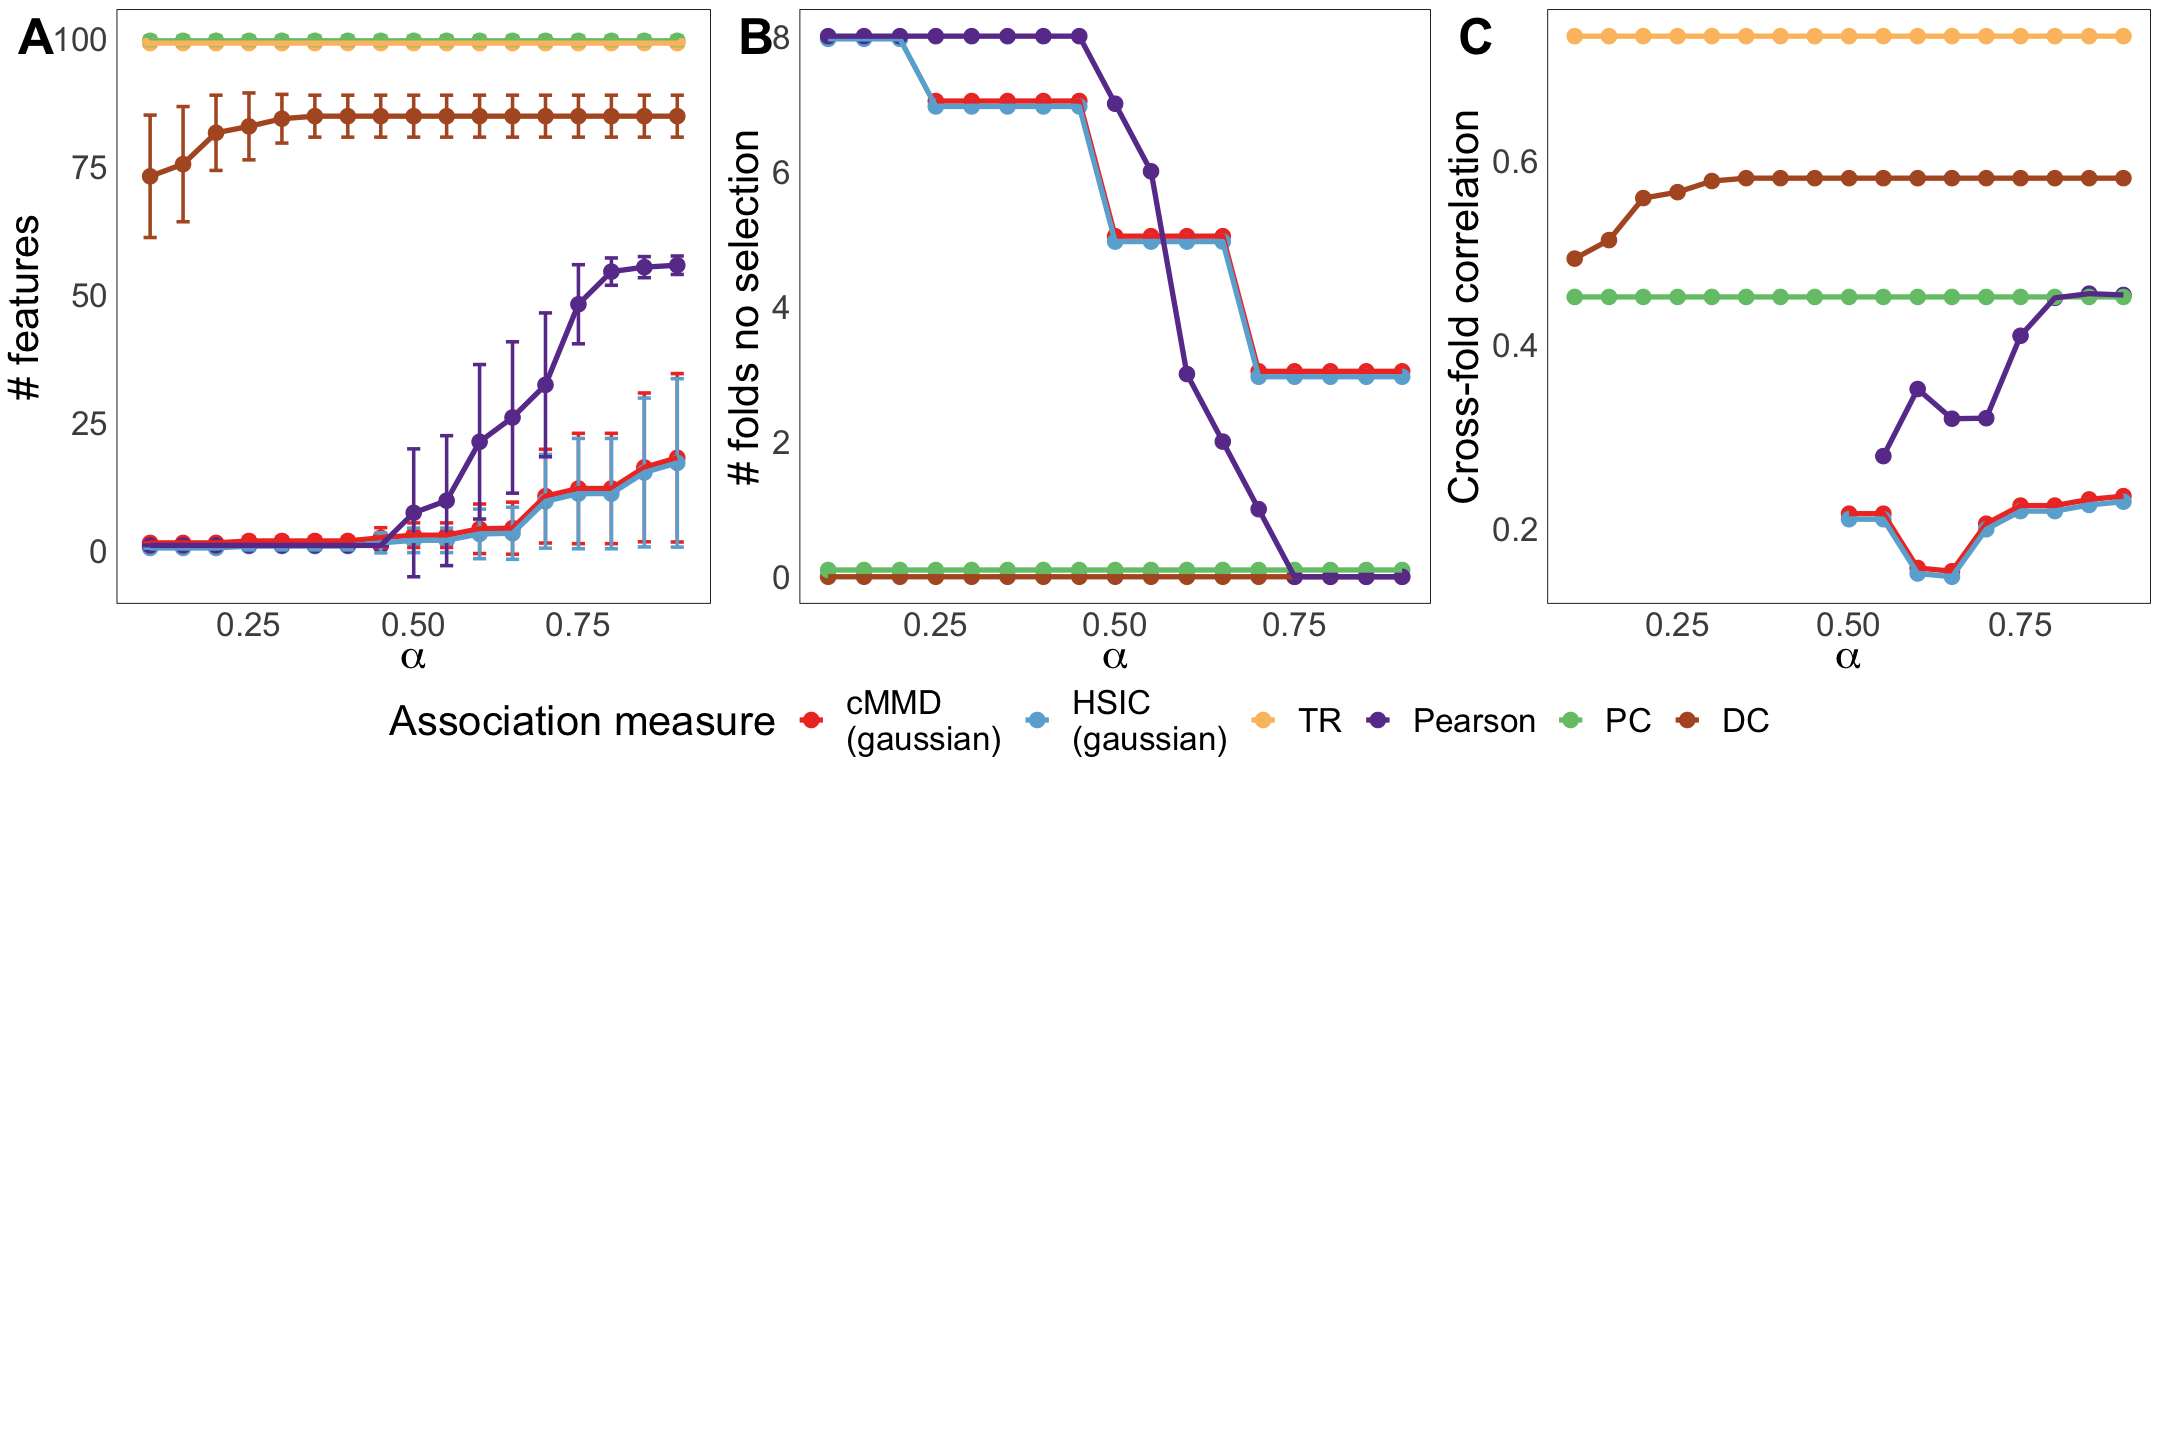

In [8]:
options(repr.plot.width=18, repr.plot.height=12)

plot_grid(plot_grid(num_features_plt + theme(legend.position = 'none'), 
                    missing_plt, pearson_plt,
                    labels = c('A', 'B', 'C'), label_size = 30, ncol = 3),
          get_legend(num_features_plt), nrow = 3, rel_heights = c(1, .1))
ggsave('../results/real_world/brca_supp.pdf', width=18, height=12, bg = "transparent")

In [9]:
brca %>%
    group_by(features) %>%
    summarize(n = n()) %>%
    arrange(-n) %>%
    head(10) %>%
    filter(!is.na(features))

features,n
<chr>,<int>
LINC01070,227
LINC00377,225
CD300LG,202
H2AFY,189
LINC02511,185
ARHGAP20,181
LINC01028,180
VEGFD,180
NACC1,177


In [10]:
top10 <- read_csv('../results/real_world/brca_scores.csv', col_types = 'cicdcddd') %>%
    mutate(features = strsplit(features, ','),
           AM = ifelse(AM == 'pearson_correlation', 'Pearson', AM),
           AM = ifelse(AM == 'HSIC', 'HSIC\n(gaussian)', AM),
           AM = ifelse(AM == 'MMD', 'cMMD\n(gaussian)', AM)) %>%
    unnest(features) %>%
    mutate(features = as.numeric(features)) %>%
    group_by(features) %>%
    summarize(n = n()) %>%
    arrange(-n) %>%
    head(11) %>%
    filter(!is.na(features))

expression_plot <- lapply(top10$features, function(i) {
    tibble(x = X[,i + 1],
           y = as.character(y),
           gene = genes[i+1])
}) %>%
    bind_rows %>%
    mutate(y = ifelse(y == 1, 'Cancer', 'Healthy')) %>%
    ggplot(aes(x = gene, y = x, fill = y)) +
        geom_boxplot() +
        scale_y_log10() +
        labs(x = 'Gene', y = 'Expression', fill = 'Status') +
        scale_fill_manual(values = c('Cancer' = '#FE8F8F',
                                     'Healthy' = '#5C7AEA')) +
        theme_minimal() +
        theme(axis.text.x = element_text(size = 35, angle = 90),
              text = element_text(size = 35),
              plot.title = element_text(size = 55),
              legend.position = 'bottom') +
        theme_transparent

In [11]:
options(repr.plot.width=15, repr.plot.height=7)
acc_plt <- brca %>%
    select(fold, AM, alpha, accuracy, sensitivity, specificity) %>%
    group_by(AM, alpha) %>%
    summarize(sd = 1.96 * sd(accuracy, na.rm = TRUE) / sqrt(n()), # fix
              accuracy = mean(accuracy, na.rm = TRUE)) %>%
    ggplot(aes(y = accuracy, x = AM)) +
        geom_bar(aes(alpha = as.character(alpha)),
                 stat = 'identity', position = 'dodge', 
                 fill = 'red', color = 'black', ) +
        geom_errorbar(aes(ymin = accuracy - sd, 
                          ymax = accuracy + sd,
                          group = alpha), 
                      position=position_dodge(width = .9), width = .7, size = 1.5) +
        labs(y = 'Test accuracy', x = 'Association measure', alpha = expression(alpha)) +
        guides(alpha = guide_legend(nrow = 2))+ 
        theme_minimal() +
        theme(text = element_text(size = 35),
              plot.title = element_text(size = 55),
              legend.position = 'bottom') +
        theme_transparent

`summarise()` has grouped output by 'AM'. You can override using the `.groups` argument.



Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 2623 rows containing non-finite values (stat_boxplot).”
Warning message:
“Using alpha for a discrete variable is not advised.”
Warning message:
“Removed 14 rows containing missing values (geom_bar).”


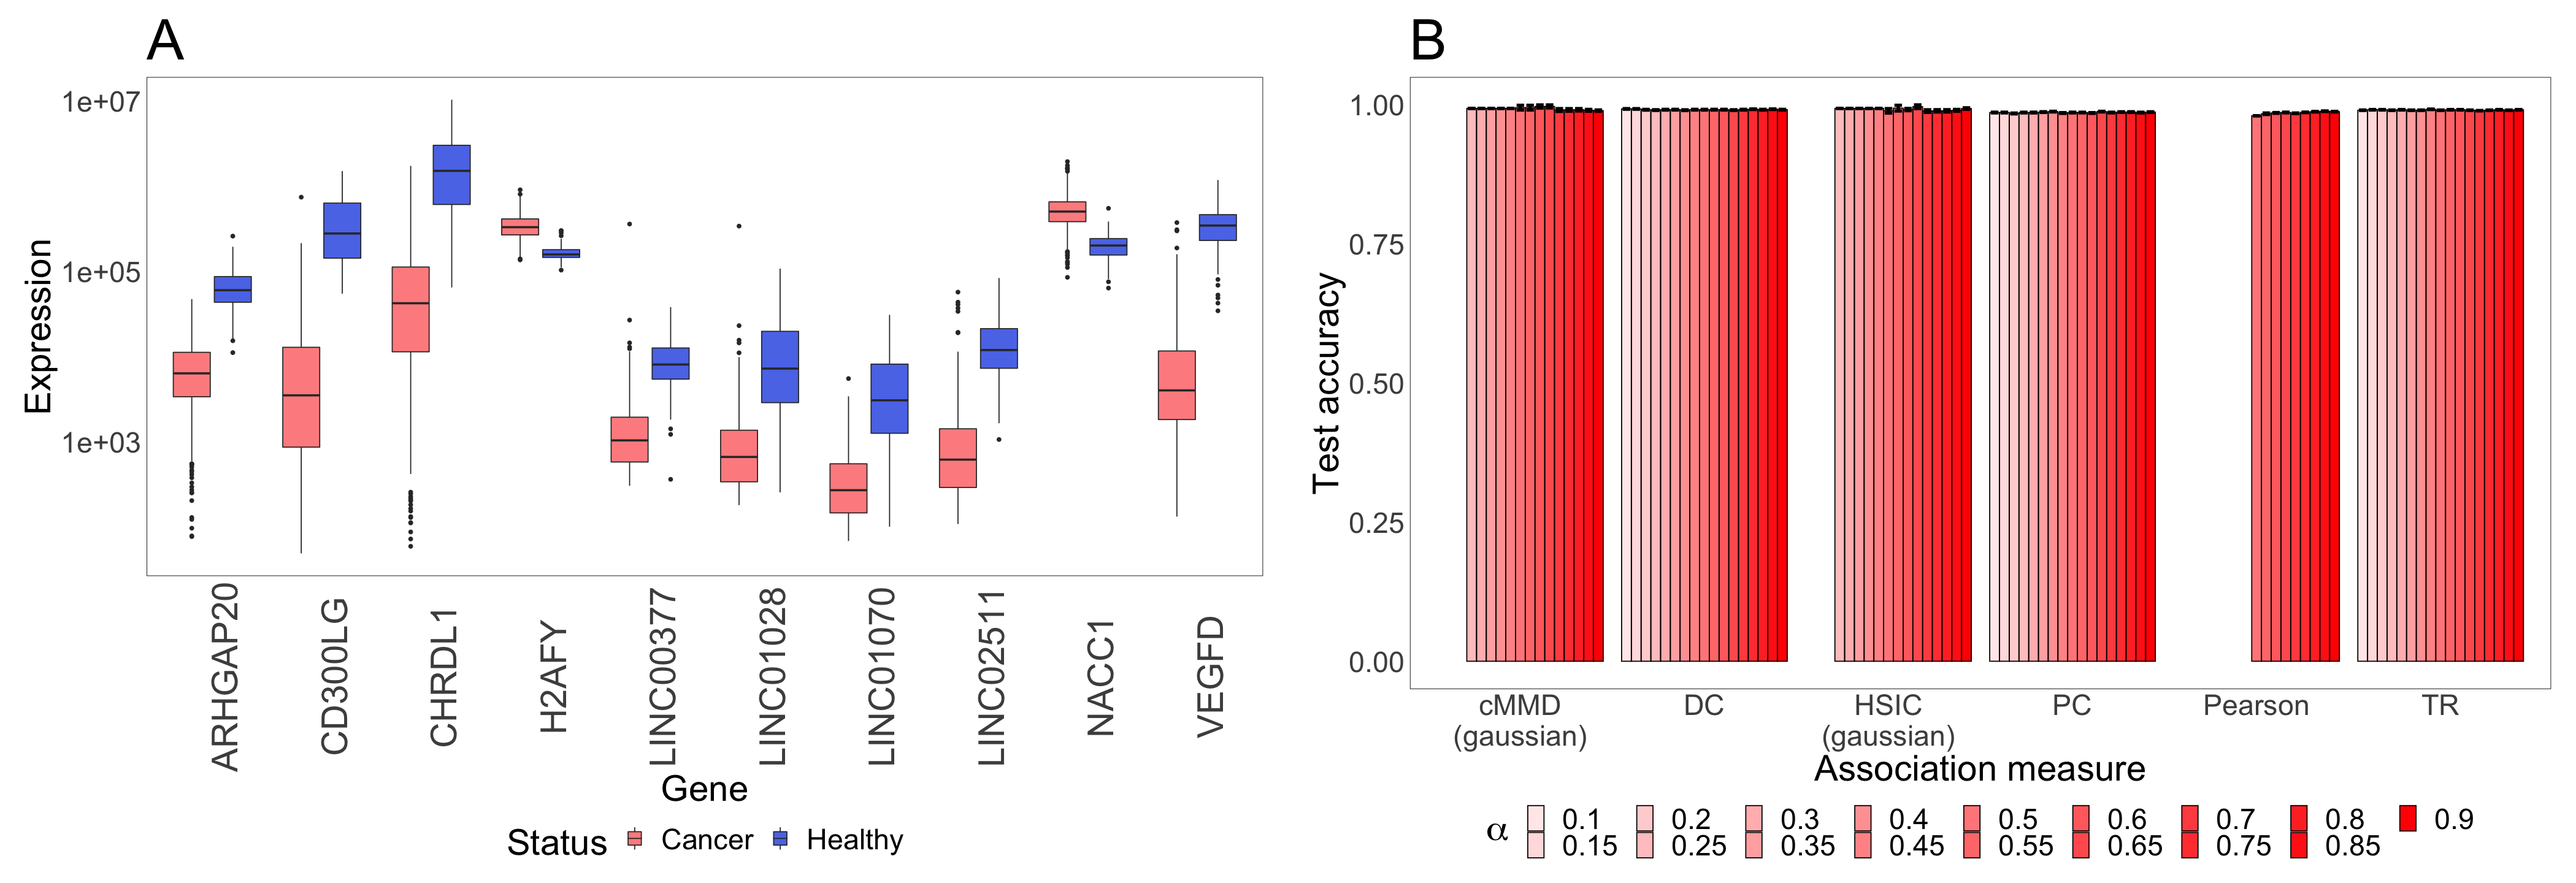

In [12]:
options(repr.plot.width=35, repr.plot.height=12)
plot_grid(expression_plot + ggtitle('A'),
          acc_plt + ggtitle('B'),
          ncol = 2, scale = 0.97)
ggsave('../results/real_world/brca.pdf', width=35, height=12, bg = "transparent")